<a href="https://colab.research.google.com/github/mahmud-nobe/Cluster-Membership/blob/master/Binary_Cluster_884_869/Cluster_membership_RF_Classifier_NGC884_and_NGC_869.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Necessary Packages

In [0]:
# import packages
import pandas as pd
import pandas_profiling as pd_prof
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Use random forest to create and evaluate new model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

In [0]:
from astropy import coordinates as coord
from astropy import units as u


In [235]:
c = coord.SkyCoord.from_name('NGC869')
print(c)
type(c.ra.degree), (c.ra.degree)
# help(c.ra)

<SkyCoord (ICRS): (ra, dec) in deg
    (34.75, 57.12833333)>


(numpy.float64, 34.75)

### Import and Examining the Training Data

Separating the predictors (features) and the output (target, here PMemb) from the dataset and train the random forest model.

In [239]:
# import binary_cluster dataset
member = pd.read_csv('https://raw.githubusercontent.com/mahmud-nobe/Cluster-Membership/master/Binary_Cluster_884_869/binary_cluster_cantat.csv')
member.head(5)

,PMemb,Cluster,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_good_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,matched_observations,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,l,b,Ecl_Lon,Ecl_Lat,ruwe,mag
0,0.4,NGC_869,4.583740e+17,34.900785,0.064429,57.115651,0.092128,0.280604,0.115781,2.423568,-0.954020,0.193125,-1.506319,0.224420,0.291596,0.045932,-0.073789,-0.023849,-0.099999,-0.070181,-0.066946,0.355147,0.146741,0.204323,257,256,-0.664703,235.7597,1.591641,1.467416,0.017286,0.015710,29,12,0.211109,33,275,1874.492486,2.791001,671.62010,17.50616,25,714.107606,11.449752,62.36883,18.21698,25,1872.888192,17.145716,109.23360,16.58064,1.380105,1.636337,0.710821,0.925516,134.713723,-3.725563,54.272177,40.308499,0.935096,17.50616
1,0.4,NGC_869,4.583780e+17,34.744249,0.028451,57.136588,0.036772,0.415407,0.044613,9.311305,-0.342761,0.108190,-0.756019,0.107569,0.316189,-0.134874,0.131029,-0.157149,-0.052478,-0.213972,-0.176294,-0.030470,0.051350,0.351416,215,203,11.826950,537.6218,325.683000,1.694376,0.006617,-0.022016,27,12,0.078062,33,226,729037.095000,351.313541,2075.17500,11.03149,18,456246.938200,1091.272124,418.08720,11.20339,20,416409.080900,587.598711,708.66240,10.71312,1.196998,0.490269,0.171897,0.318372,134.626455,-3.734167,54.183223,40.363816,1.003925,11.03149
2,0.2,NGC_869,4.583690e+17,34.694726,0.028647,57.068887,0.048743,0.344598,0.052692,6.539835,-0.145917,0.091854,-0.698945,0.134082,0.371276,-0.024583,0.106852,0.084624,-0.332651,0.076955,0.268010,0.009693,-0.177497,0.436573,203,202,0.193541,200.1921,12.904060,1.522582,0.007264,0.080092,23,12,0.137341,26,220,11173.889270,130.937761,85.33741,15.56785,20,5364.417081,200.700974,26.72840,16.02758,19,9020.522759,378.096019,23.85776,14.87384,1.287371,1.153742,0.459727,0.694015,134.623561,-3.806959,54.113247,40.314197,1.076254,15.56785
3,0.6,NGC_869,4.583630e+17,35.115957,0.040829,57.116405,0.057991,0.366438,0.069009,5.310025,-0.502487,0.120633,-1.183384,0.145989,0.272231,0.015069,-0.109043,-0.049295,-0.286923,-0.126445,-0.091074,0.282671,0.098422,0.330313,257,257,2.333040,307.3275,4.125995,1.458216,0.011843,0.071515,29,13,0.146031,31,264,4334.607666,3.808885,1138.02500,16.59599,25,1729.850628,11.357713,152.30620,17.25637,25,3945.219381,15.587598,253.09990,15.77174,1.309247,1.484625,0.660376,0.824249,134.823723,-3.685572,54.411072,40.259285,1.099435,16.59599
4,0.3,NGC_869,4.583680e+17,34.685825,0.032343,57.024972,0.044876,0.374779,0.058827,6.370851,-0.932498,0.109590,-0.710651,0.125569,0.197556,-0.126714,0.090484,-0.216156,-0.048625,-0.241330,0.058606,0.160396,0.269046,0.113653,219,218,-0.205140,208.1368,9.007986,1.504834,0.008089,-0.047578,25,12,0.121323,27,236,8317.347295,4.947565,1681.09900,15.88840,23,3700.258468,27.959830,132.34190,16.43081,24,6848.665891,17.223600,397.63270,15.17290,1.268304,1.257902,0.542403,0.715499,134.633582,-3.849994,54.082822,40.276601,1.029976,15.88840


In [240]:
# Examining the descriptive statistics of each column
member.describe()

,PMemb,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_good_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,matched_observations,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,l,b,Ecl_Lon,Ecl_Lat,ruwe,mag
count,2529.000000,2.529000e+03,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2.529000e+03,2529.000000,2529.000000,2529.000000,2529.000000,2.510000e+03,2510.000000,2510.000000,2510.000000,2529.000000,2.508000e+03,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2510.000000,2508.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000
mean,0.513523,4.584123e+17,35.150624,0.034070,57.139672,0.045983,0.394491,0.057550,8.594877,-0.643961,0.105719,-1.040802,0.120865,0.311976,0.014023,-0.075534,-0.109294,-0.165364,-0.164137,-0.127659,0.274020,0.166737,0.322380,244.210360,242.436536,0.382802,264.466826,50.400885,1.566174,0.008794,0.020197,27.975484,12.300909,0.123940,31.096876,255.188612,2.148981e+05,208.810917,2054.339208,15.180414,25.942665,1.199076e+05,374.499786,311.493613,15.585593,25.661526,1.420331e+05,500.030329,484.634978,14.563353,1.265785,1.021516,0.412727,0.608301,134.833256,-3.656353,54.446493,40.272734,1.003738,15.180414
std,0.246444,5.824269e+13,0.495088,0.018916,0.112939,0.024537,0.052133,0.031363,3.837874,0.222603,0.060882,0.230910,0.063408,0.094420,0.103648,0.155022,0.088790,0.100524,0.092189,0.168343,0.138200,0.130894,0.116083,27.438093,27.363875,4.731427,340.185188,89.148479,0.078436,0.004918,0.045172,3.091080,0.973950,0.063896,2.620458,27.601747,2.189266e+06,2818.535631,1109.396144,1.825734,5.077590,1.149224e+06,4567.084438,201.852091,1.968912,5.212125,1.571105e+06,7225.098145,273.861085,1.670497,0.086296,0.360290,0.184001,0.189849,0.257073,0.138197,0.323084,0.155329,0.161572,1.825734
min,0.100000,4.583060e+17,34.357227,0.012364,56.821045,0.015758,0.275084,0.019534,1.715636,-1.549781,0.035347,-1.879070,0.041936,-0.511997,-0.749796,-0.862190,-0.519568,-0.739592,-0.542515,-0.884107,-0.385678,-0.446879,-0.546290,104.000000,102.000000,-7.395707,63.128360,0.600071,1.344988,0.003004,-0.235193,12.000000,6.000000,0.051067,15.000000,121.000000,1.190792e+03,1.566375,85.337410,6.210630,0.000000,3.994005e+02,5.182615,2.906666,6.576396,0.000000,1.006071e+03,5.811439,5.648611,5.707510,1.173863,0.276914,-0.843611,0.180429,134.401118,-4.005285,53.890940,39.817701,0.757964,6.210630
25%,0.300000,4.583740e+17,34.721340,0.021245,57.071251,0.029197,0.358008,0.035758,5.487058,-0.763235,0.064998,-1.175979,0.077210,0.259599,-0.040700,-0.172164,-0.169081,-0.224885,-0.225464,-0.242695,0.213258,0.095728,0.251737,229.000000,228.000000,-2.087318,191.134700,4.950457,1.505068,0.005381,-0.006671,26.000000,12.000000,0.078399,30.000000,241.000000,4.896437e+03,4.054820,1195.850000,14.246650,24.000000,2.164294e+03,13.728136,137.850725,14.513177,24.000000,4.249179e+03,13.485217,264.220900,13.789770,1.217670,0.721107,0.265256,0.452178,134.6122

In [0]:
### adding their distance from the center of both clusters

## NGC 869
center = coord.SkyCoord.from_name('NGC869')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( (member['ra'] - center_ra)**2 + (member['dec'] - center_dec)**2 )
member['dist_869_center'] = distance

## NGC 884
center = coord.SkyCoord.from_name('NGC884')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( (member['ra'] - center_ra)**2 + (member['dec'] - center_dec)**2 )
member['dist_884_center'] = distance


In [242]:
field_star = member['PMemb'] < 0.5
member['Cluster'][field_star] = 'Field'
member['Cluster'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Field      988
NGC_869    920
NGC_884    621
Name: Cluster, dtype: int64

In [243]:
# correlation of PMemb with other variables
member.corr().PMemb.sort_values()

ra_error                          -0.488393
astrometric_pseudo_colour_error   -0.486473
pmra_error                        -0.479879
parallax_error                    -0.479258
dec_error                         -0.474843
                                     ...   
phot_bp_mean_flux_over_error       0.376905
phot_g_mean_flux_over_error        0.408435
astrometric_pseudo_colour          0.421204
parallax_over_error                0.464685
PMemb                              1.000000
Name: PMemb, Length: 62, dtype: float64

In [0]:
# Profile report of the full dataset
# pd_prof.ProfileReport(member)

In [245]:
# Choosing the predictors
features = member.loc[:,['ra',	'ra_error',	'dec', 'dec_error',	
                         'parallax', 'parallax_error',	'parallax_over_error', 
                         'pmra',	'pmra_error',	'pmdec',	'pmdec_error',
                         'phot_g_mean_mag', 'bp_rp', 'dist_869_center', 'dist_884_center']]
features

,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,dist_869_center,dist_884_center
0,34.900785,0.064429,57.115651,0.092128,0.280604,0.115781,2.423568,-0.954020,0.193125,-1.506319,0.224420,17.50616,1.636337,0.151317,0.695111
1,34.744249,0.028451,57.136588,0.036772,0.415407,0.044613,9.311305,-0.342761,0.108190,-0.756019,0.107569,11.03149,0.490269,0.010061,0.851663
2,34.694726,0.028647,57.068887,0.048743,0.344598,0.052692,6.539835,-0.145917,0.091854,-0.698945,0.134082,15.56785,1.153742,0.081174,0.902853
3,35.115957,0.040829,57.116405,0.057991,0.366438,0.069009,5.310025,-0.502487,0.120633,-1.183384,0.145989,16.59599,1.484625,0.366152,0.479953
4,34.685825,0.032343,57.024972,0.044876,0.374779,0.058827,6.370851,-0.932498,0.109590,-0.710651,0.125569,15.88840,1.257902,0.121664,0.915490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2524,35.475146,0.095398,57.108823,0.122610,0.407836,0.162771,2.505576,-0.068968,0.273169,-1.517004,0.294510,17.95529,1.558842,0.725409,0.121766
2525,35.820625,0.022487,57.127543,0.029916,0.401755,0.039344,10.211430,-0.490251,0.069581,-0.933062,0.081387,15.14565,0.795093,1.070625,0.224806
2526,35.504081,0.045745,57.113965,0.054992,0.313777,0.068182,4.602029,-1.096121,0.125295,-0.913376,0.135664,16.56910,1.390498,0.754218,0.092413
2527,35.875661,0.027769,57.121199,0.035907,0.455219,0.045458,10.014000,-0.395499,0.084740,-0.937896,0.100190,15.64349,0.929671,1.125684,0.279853


In [246]:
# Descriptive stats
features.describe()

,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,dist_869_center,dist_884_center
count,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2529.000000,2508.000000,2529.000000,2529.000000
mean,35.150624,0.034070,57.139672,0.045983,0.394491,0.057550,8.594877,-0.643961,0.105719,-1.040802,0.120865,15.180414,1.021516,0.508950,0.572751
std,0.495088,0.018916,0.112939,0.024537,0.052133,0.031363,3.837874,0.222603,0.060882,0.230910,0.063408,1.825734,0.360290,0.399284,0.358048
min,34.357227,0.012364,56.821045,0.015758,0.275084,0.019534,1.715636,-1.549781,0.035347,-1.879070,0.041936,6.210630,0.276914,0.003802,0.007013
25%,34.721340,0.021245,57.071251,0.029197,0.358008,0.035758,5.487058,-0.763235,0.064998,-1.175979,0.077210,14.246650,0.721107,0.162184,0.206158
50%,34.980025,0.027732,57.140006,0.038157,0.393968,0.047214,8.276686,-0.648053,0.085760,-1.058378,0.101713,15.522440,0.986889,0.320477,0.628859
75%,35.586616,0.040742,57.208628,0.054575,0.430648,0.068874,11.241740,-0.523913,0.126527,-0.928115,0.143687,16.463670,1.301018,0.845141,0.882566
max,36.154135,0.181060,57.449600,0.205539,0.526242,0.251486,19.554680,0.300520,0.760247,-0.086586,0.601490,17.998780,2.581698,1.404309,1.238802


In [0]:
features2 = member.iloc[:,3:-1]
features2

,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_good_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,matched_observations,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,l,b,Ecl_Lon,Ecl_Lat,ruwe
0,34.900785,0.064429,57.115651,0.092128,0.280604,0.115781,2.423568,-0.954020,0.193125,-1.506319,0.224420,0.291596,0.045932,-0.073789,-0.023849,-0.099999,-0.070181,-0.066946,0.355147,0.146741,0.204323,257,256,-0.664703,235.7597,1.591641,1.467416,0.017286,0.015710,29,12,0.211109,33,275,1874.492486,2.791001,671.62010,17.50616,25,714.107606,11.449752,62.36883,18.21698,25,1872.888192,17.145716,109.23360,16.58064,1.380105,1.636337,0.710821,0.925516,134.713723,-3.725563,54.272177,40.308499,0.935096
1,34.744249,0.028451,57.136588,0.036772,0.415407,0.044613,9.311305,-0.342761,0.108190,-0.756019,0.107569,0.316189,-0.134874,0.131029,-0.157149,-0.052478,-0.213972,-0.176294,-0.030470,0.051350,0.351416,215,203,11.826950,537.6218,325.683000,1.694376,0.006617,-0.022016,27,12,0.078062,33,226,729037.095000,351.313541,2075.17500,11.03149,18,456246.938200,1091.272124,418.08720,11.20339,20,416409.080900,587.598711,708.66240,10.71312,1.196998,0.490269,0.171897,0.318372,134.626455,-3.734167,54.183223,40.363816,1.003925
2,34.694726,0.028647,57.068887,0.048743,0.344598,0.052692,6.539835,-0.145917,0.091854,-0.698945,0.134082,0.371276,-0.024583,0.106852,0.084624,-0.332651,0.076955,0.268010,0.009693,-0.177497,0.436573,203,202,0.193541,200.1921,12.904060,1.522582,0.007264,0.080092,23,12,0.137341,26,220,11173.889270,130.937761,85.33741,15.56785,20,5364.417081,200.700974,26.72840,16.02758,19,9020.522759,378.096019,23.85776,14.87384,1.287371,1.153742,0.459727,0.694015,134.623561,-3.806959,54.113247,40.314197,1.076254
3,35.115957,0.040829,57.116405,0.057991,0.366438,0.069009,5.310025,-0.502487,0.120633,-1.183384,0.145989,0.272231,0.015069,-0.109043,-0.049295,-0.286923,-0.126445,-0.091074,0.282671,0.098422,0.330313,257,257,2.333040,307.3275,4.125995,1.458216,0.011843,0.071515,29,13,0.146031,31,264,4334.607666,3.808885,1138.02500,16.59599,25,1729.850628,11.357713,152.30620,17.25637,25,3945.219381,15.587598,253.09990,15.77174,1.309247,1.484625,0.660376,0.824249,134.823723,-3.685572,54.411072,40.259285,1.099435
4,34.685825,0.032343,57.024972,0.044876,0.374779,0.058827,6.370851,-0.932498,0.109590,-0.710651,0.125569,0.197556,-0.126714,0.090484,-0.216156,-0.048625,-0.241330,0.058606,0.160396,0.269046,0.113653,219,218,-0.205140,208.1368,9.007986,1.504834,0.008089,-0.047578,25,12,0.121323,27,236,8317.347295,4.947565,1681.09900,15.88840,23,3700.258468,27.959830,132.34190,16.43081,24,6848.665891,17.223600,397.63270,15.17290,1.268304,1.257902,0.542403,0.715499,134.633582,-3.849994,54.082822,40.276601,1.029976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2524,35.475146,0.095398,57.108823,0.122610,0.407836,0.162771,2.505576,-0.068968,0.273169,-1.517004,0.294510,0.342703,0.095274,-0.188572,-0.169951,-0.283712,-0.303498,-0.211701,0.415677,0.269763,0.446755,266,262,1.575793,293.6774,0.860183,1.466080,0.024057,-0.005690,30,12,0.310477,35,284,1239.453201,4.766017,260.06060,17.95529,28,502.1901

In [247]:
# The outcome that we want to use to train our model
targets = member['Cluster']
targets

0         Field
1         Field
2         Field
3       NGC_869
4         Field
         ...   
2524      Field
2525    NGC_884
2526      Field
2527      Field
2528    NGC_884
Name: Cluster, Length: 2529, dtype: object

In [248]:
# Dropping the NULL values from the using training set
# adding features and targets in a training set
training_set = pd.concat((features, targets), axis=1)

# dropping NA
training_set = training_set.dropna()

# set features, targets again
features, targets = training_set.iloc[:,:-1], training_set.iloc[:,-1]

features.describe()

,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,bp_rp,dist_869_center,dist_884_center
count,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000
mean,35.150426,0.033853,57.139659,0.045626,0.394543,0.057250,8.621974,-0.643196,0.105055,-1.041295,0.120020,15.171654,1.021516,0.509177,0.573281
std,0.495617,0.018471,0.113090,0.023875,0.052178,0.030931,3.833411,0.221040,0.059059,0.229483,0.061955,1.827229,0.360290,0.399492,0.358225
min,34.357227,0.012364,56.821045,0.015758,0.275084,0.019534,1.715636,-1.549781,0.035347,-1.879070,0.041936,6.210630,0.276914,0.003802,0.007013
25%,34.720499,0.021183,57.071125,0.029152,0.357971,0.035740,5.539387,-0.761941,0.064885,-1.175736,0.077033,14.240150,0.721107,0.162219,0.206372
50%,34.979644,0.027635,57.139874,0.038012,0.394041,0.046979,8.339009,-0.647954,0.085589,-1.058582,0.101452,15.507570,0.986889,0.320719,0.629738
75%,35.586815,0.040513,57.208642,0.054237,0.430650,0.068349,11.276222,-0.523544,0.126027,-0.928571,0.142430,16.458578,1.301018,0.845177,0.883560
max,36.154135,0.144425,57.449600,0.152741,0.526242,0.195085,19.554680,0.300520,0.472243,-0.086586,0.521269,17.998780,2.581698,1.404309,1.238802


In [249]:
# Probable members (PMemb >= 0.5) in this dataset
len(member[member['Cluster'] != 'Field'])

1541

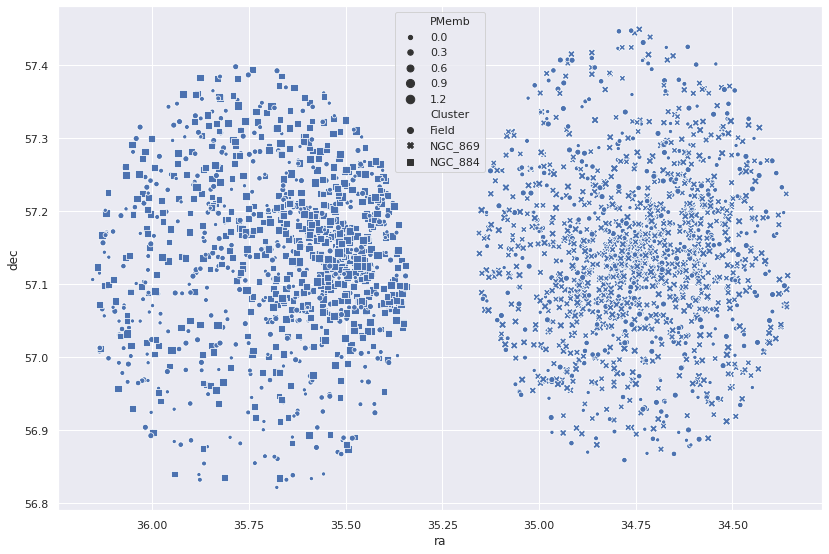

In [21]:
sns.set(rc={'figure.figsize':(13.7,9.27)})

skyplot = sns.scatterplot(member['ra'], member['dec'], style=member['Cluster'], palette='Greens', size = member['PMemb'])
skyplot.invert_xaxis()

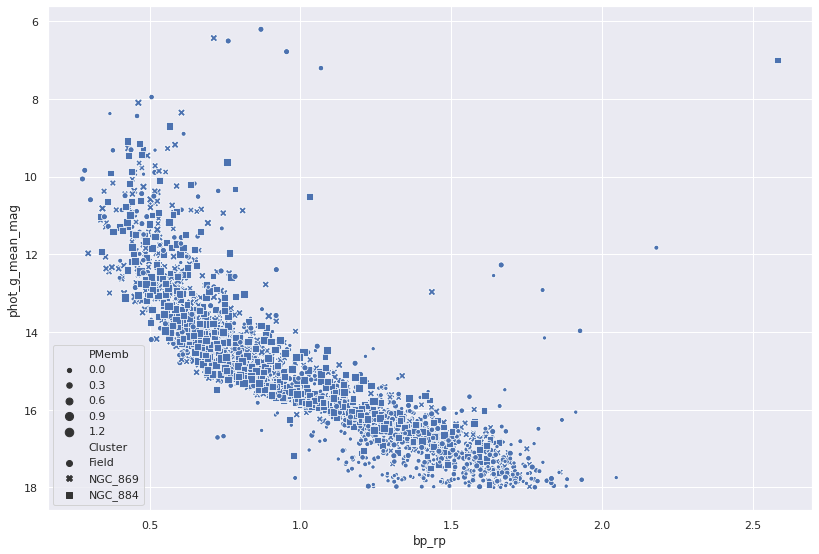

In [0]:
# CMD marked with the membership probabilities of the stars 
# (PMemb >= 0.5 stars are the probable stars)

cmd = sns.scatterplot(member['bp_rp'], member['phot_g_mean_mag'], style=member['Cluster'], palette='Greens', size = member['PMemb'])
cmd.invert_yaxis()

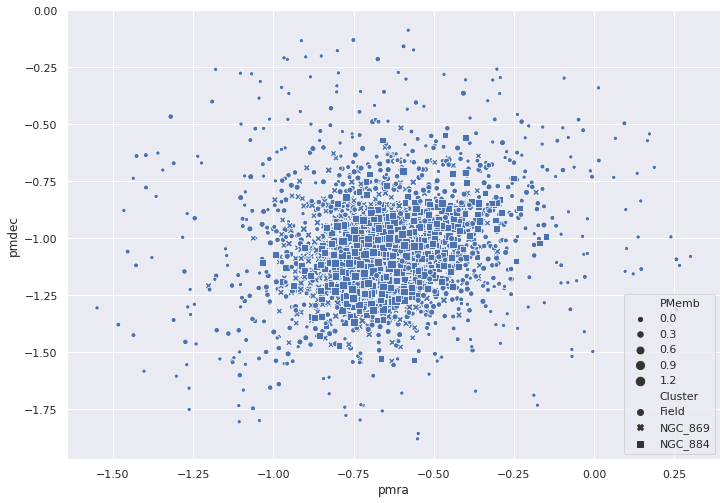

In [0]:
# proper motion plot marked with the membership probabilities of the stars 

sns.set(rc={'figure.figsize':(11.7,8.27)})
pm_plot = sns.scatterplot(member['pmra'], member['pmdec'], style=member['Cluster'], size = member['PMemb'])

In [0]:
# data type of each variable
member.dtypes

PMemb        float64
Cluster       object
source_id    float64
ra           float64
ra_error     float64
              ...   
b            float64
Ecl_Lon      float64
Ecl_Lat      float64
ruwe         float64
mag          float64
Length: 61, dtype: object

In [0]:
type(targets)
targets.dtypes
targets.isna().sum()

0

In [250]:
# changing the data type to 32-bit-float number as the built-in radom forest package 
# don't take 64-bit-float
from numpy import float32
features = features.astype('float32')
# targets = targets.astype('float32')
features.dtypes

ra                     float32
ra_error               float32
dec                    float32
dec_error              float32
parallax               float32
parallax_error         float32
parallax_over_error    float32
pmra                   float32
pmra_error             float32
pmdec                  float32
pmdec_error            float32
phot_g_mean_mag        float32
bp_rp                  float32
dist_869_center        float32
dist_884_center        float32
dtype: object

In [251]:
# Use Random Forest on whole dataset using 100 different trees 
rfc = RandomForestClassifier(n_estimators = 1000, oob_score = True)
rfc.fit(features, targets)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [252]:
# checking the feature importance, 
# ( this is higher for a variable if the model efficiency become lower as we remove that variable)
feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending = False)
feature_imp

ra                     0.137800
dist_869_center        0.132877
dist_884_center        0.110233
pmdec                  0.104469
pmra                   0.102479
parallax_over_error    0.057206
ra_error               0.047033
parallax               0.045313
pmra_error             0.042018
pmdec_error            0.038654
dec_error              0.038626
phot_g_mean_mag        0.037619
parallax_error         0.036434
bp_rp                  0.034798
dec                    0.034440
dtype: float64

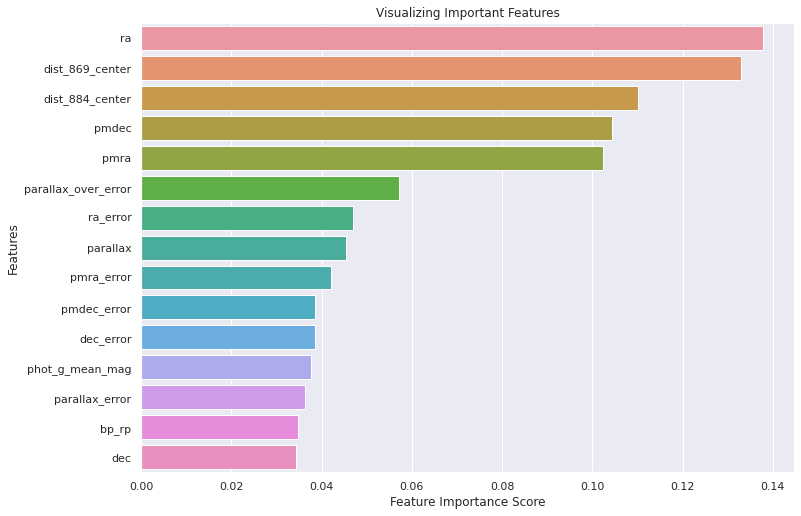

In [253]:
# plotting as a barplot

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Estimating the Model Accuracy in Test Data

In [0]:
# function for splitting a given dataset into training and test dataset

import random
# X = predictors, Y = target
def test_train_split(X, Y, test_ratio):
  ntest = int(len(X)*test_ratio) 
  ntrain = int(len(X) - ntest)

  # randomly select ntest number of rows from the full dataset as test_index and mark others as train_index.
  ind_test = random.sample(range(len(X)), k = ntest)
  ind_train = list(set(range(len(X))) - set(ind_test))

  # test and train dataset has the observations of test_indices and train_indices respectively
  test_X = X.iloc[ind_test]
  test_Y = Y.iloc[ind_test]

  train_X = X.iloc[ind_train]
  train_Y = Y.iloc[ind_train]

  return test_X, test_Y, train_X, train_Y

In [0]:
# splitting our dataset using 0.3 test ratio (30% test data, 70% train data)
test_features, test_targets, train_features, train_targets = test_train_split(features, targets, 0.3)


In [256]:
# train the model using only training subset
rfc.fit(train_features, train_targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [257]:
# find the accuracy rate to predict the outcome for test subset
test_predict = rfc.predict(test_features)
rfc.score(test_features, test_targets)

0.788563829787234

[[0.67105263 0.18092105 0.14802632]
 [0.10384615 0.89615385 0.        ]
 [0.17021277 0.         0.82978723]]


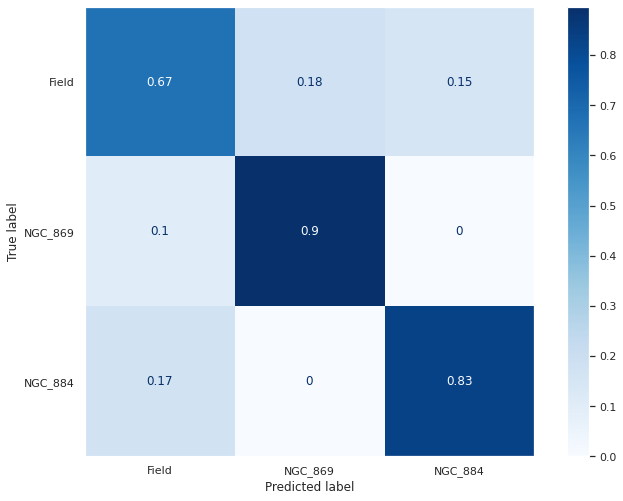

In [259]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(rfc, test_features, test_targets,
display_labels=rfc.classes_, cmap=plt.cm.Blues, normalize = 'true')
plt.grid(False)

print(disp.confusion_matrix)

In [260]:
# Check with different test ratio

test_ratio = np.linspace(0.95, 0.05, 19)
print(test_ratio)

[0.95 0.9  0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35 0.3
 0.25 0.2  0.15 0.1  0.05]


In [261]:
# for each test_ratio, estimate the accuracy of the model

accuracy_rate = []

for ratio in test_ratio:
  test_features, test_targets, train_features, train_targets = test_train_split(features, targets, ratio)

  # train the model using only training subset
  rfc.fit(train_features, train_targets)

  # find the accuracy rate to predict the outcome for test subset
  test_predict = rfc.predict(test_features)
  accuracy = rfc.score(test_features, test_targets)

  accuracy_rate.append(accuracy)

print(accuracy_rate)

[0.7082283795130143, 0.7523260965883917, 0.7705302674800563, 0.7896311066799602, 0.7985114300903775, 0.7982905982905983, 0.7877300613496933, 0.8018617021276596, 0.8158085569253082, 0.8141945773524721, 0.8014184397163121, 0.8095712861415753, 0.7890535917901939, 0.8071808510638298, 0.8054226475279107, 0.810379241516966, 0.8218085106382979, 0.86, 0.824]


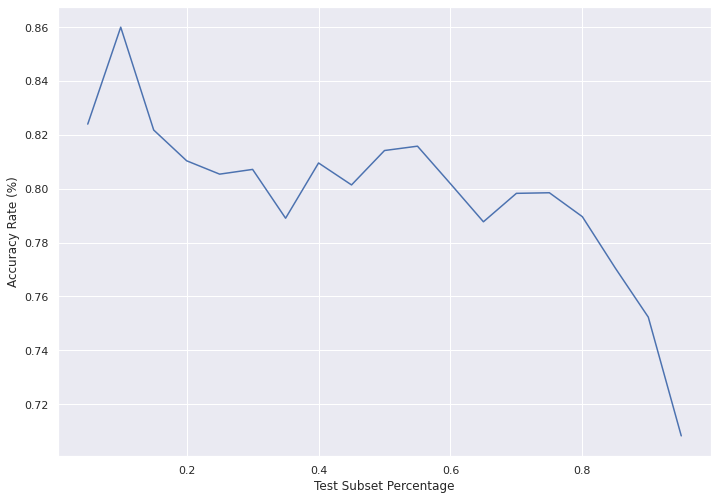

In [262]:
# plotting the accuracy rate vs test-ratio

sns.lineplot(test_ratio, accuracy_rate)
plt.xlabel('Test Subset Percentage')
plt.ylabel('Accuracy Rate (%)')
plt.show()

### Prediction of PMemb for the new stars

In [263]:
# Import all the stars from GAIA data around 30 m radius of cluster center
all_stars = pd.read_csv('binary_cluster_gaia60m.zip')
all_stars

,Unnamed: 0,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_good_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,matched_observations,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,l,b,Ecl_Lon,Ecl_Lat,ruwe
0,0,458456770672134656,35.250190,0.062535,57.125830,0.082797,0.268473,0.103411,2.596172,-0.685945,0.191002,-1.145181,0.234310,0.341222,-0.032741,-0.176181,-0.102958,-0.278001,-0.179046,-0.177540,0.313080,0.061949,0.398542,296,296,1.979570,340.67550,1.642403,1.504278,0.016991,0.006647,34,13,0.232124,37,301,1971.35880,2.299440,857.32130,17.45145,27,857.558400,8.868372,96.698520,18.01823,26,1749.385700,6.606804,264.78550,16.65471,1.322410,1.363522,0.566776,0.796745,134.88922,-3.652018,54.502712,40.236774,1.055825
1,1,458456805031733632,35.252296,0.029433,57.127090,0.039981,1.065622,0.051342,20.755340,15.712064,0.091204,-9.020601,0.111302,0.294447,-0.042395,-0.104000,-0.080159,-0.274819,-0.152235,-0.052534,0.293467,0.096075,0.309494,291,289,-0.218659,278.16250,7.654071,1.476520,0.007971,-0.036219,34,13,0.114226,35,288,7091.66700,4.629174,1531.95100,16.06149,31,2792.340800,16.069143,173.770400,16.73647,28,6353.586400,13.676645,464.55730,15.25437,1.289672,1.482095,0.674973,0.807122,134.88988,-3.650444,54.504770,40.237430,1.007278
2,2,458453845788270848,35.254670,0.024347,57.124530,0.031806,0.401020,0.040829,9.821923,-0.576387,0.074206,-0.976388,0.078845,0.278386,0.034167,-0.114677,-0.086290,-0.232977,-0.167748,-0.243002,0.352679,0.214055,0.300213,304,302,-0.135504,293.04850,11.429910,1.524400,0.006640,-0.022950,35,13,0.088532,36,309,10170.14550,5.189207,1959.86500,15.67005,31,4607.870600,12.640005,364.546600,16.19264,30,8308.719000,12.471944,666.19270,14.96309,1.270050,1.229553,0.522591,0.706963,134.89197,-3.652415,54.504868,40.234562,1.050665
3,3,458453850088715904,35.255016,0.391105,57.123890,0.493029,0.904775,0.639175,1.415536,3.338108,1.318452,0.109943,1.357960,0.435948,-0.165929,-0.337579,-0.252474,-0.378123,-0.366560,-0.409113,0.451045,0.184211,0.519032,266,263,1.793638,300.18790,0.056664,1.414572,0.099486,-0.053649,31,11,1.481248,34,274,173.89961,1.236317,140.65930,20.08762,11,199.541990,17.515450,11.392340,19.60130,10,351.584050,26.771563,13.13274,18.39685,3.169220,1.204456,-0.486317,1.690773,134.89235,-3.652954,54.504734,40.233906,1.049487
4,4,458453811431452672,35.251640,0.090171,57.121777,0.109517,0.831151,0.155086,5.359301,-0.195090,0.264210,-1.001422,0.246366,0.210336,0.056259,-0.128365,-0.001163,-0.287295,-0.151238,-0.109373,0.448293,0.291686,0.273285,282,280,1.000372,298.42970,0.836352,1.419206,0.024659,-0.020484,32,13,0.263755,35,290,1096.44970,2.934504,373.64060,18.08839,28,439.442780,12.123909,36.245970,18.74413,29,1164.394400,19.529432,59.62254,17.09667,1.462755,1.647463,0.655739,0.991724,134.89134,-3.655564,54.501385,40.232770,0.996634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197379,197379,457518195754219136,36.327507,0.282476,56.318497,0.309065,1.036946,0.441226,2.350146,-7.810198,0.760064,-3.086631,0.681734,0.290299,0.069167,-0.170188,0.033158,-0.111271,-0.063325,0.106565,0.390318,0.079853,0.16

In [0]:
### adding their distance from the center of both clusters

## NGC 869
center = coord.SkyCoord.from_name('NGC869')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( (all_stars['ra'] - center_ra)**2 + (all_stars['dec'] - center_dec)**2 )
all_stars['dist_869_center'] = distance

## NGC 884
center = coord.SkyCoord.from_name('NGC884')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( (all_stars['ra'] - center_ra)**2 + (all_stars['dec'] - center_dec)**2 )
all_stars['dist_884_center'] = distance


In [25]:
# checking the data types
all_stars.dtypes

Unnamed: 0                            int64
source_id                             int64
ra                                  float64
ra_error                            float64
dec                                 float64
dec_error                           float64
parallax                            float64
parallax_error                      float64
parallax_over_error                 float64
pmra                                float64
pmra_error                          float64
pmdec                               float64
pmdec_error                         float64
ra_dec_corr                         float64
ra_parallax_corr                    float64
ra_pmra_corr                        float64
ra_pmdec_corr                       float64
dec_parallax_corr                   float64
dec_pmra_corr                       float64
dec_pmdec_corr                      float64
parallax_pmra_corr                  float64
parallax_pmdec_corr                 float64
pmra_pmdec_corr                 

In [265]:
# descriptive stats
all_stars.describe()

,Unnamed: 0,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_good_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,matched_observations,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,l,b,Ecl_Lon,Ecl_Lat,ruwe,dist_869_center,dist_884_center
count,197384.000000,1.973840e+05,197384.000000,197384.000000,197384.000000,197384.000000,167355.000000,167355.000000,167355.000000,167355.000000,167355.000000,167355.000000,167355.000000,197384.000000,167355.000000,167355.000000,167355.000000,167355.000000,167355.000000,167355.000000,167355.000000,167355.000000,167355.000000,197384.000000,197384.000000,197384.000000,1.973840e+05,197384.000000,166789.000000,166789.000000,197384.000000,197384.000000,197384.000000,1.973840e+05,197384.000000,197384.000000,1.973840e+05,197384.000000,197384.000000,197384.000000,197384.000000,1.805690e+05,180569.000000,180569.000000,180569.000000,197384.000000,1.805940e+05,1.805940e+05,180594.000000,180594.000000,180539.000000,180539.000000,180569.000000,180594.000000,197384.000000,197384.000000,197384.000000,197384.000000,167355.000000,197384.000000,197384.000000
mean,98691.500000,4.582998e+17,35.245069,0.676103,57.123145,0.737186,0.413405,0.436871,3.136808,0.178861,0.923719,-0.822792,0.891137,0.280932,-0.110786,-0.039159,-0.053099,-0.189720,-0.098839,0.016879,0.205214,0.134912,0.268925,216.874529,215.667136,2.790882,8.193064e+02,4.507423,1.448662,0.067851,-0.031971,24.990070,11.224127,7.876740e+03,27.198927,225.933738,1.447461e+04,17.325044,556.693097,18.933553,20.735804,7.492382e+03,36.305978,69.877729,19.304873,21.520488,1.235311e+04,5.431619e+01,135.905625,17.835136,1.533247,1.470132,0.516581,0.953598,134.886430,-3.652236,54.499751,40.236707,1.081343,1.026215,0.990077
std,56979.997104,4.250813e+14,0.910910,1.649254,0.489762,1.802091,0.880118,0.379540,8.778893,4.597628,0.868358,3.460629,0.851091,0.208895,0.155366,0.216502,0.150349,0.156156,0.157369,0.208709,0.213067,0.198354,0.180701,64.629166,64.379050,14.133536,2.352530e+04,26.706627,0.121589,0.058943,0.074755,7.123036,2.386800,3.827382e+05,7.722221,67.813758,5.979438e+05,1413.860922,752.074597,1.816517,9.414922,2.717980e+05,1914.646894,140.529114,1.754790,9.244788,5.623489e+05,4.019622e+03,333.701648,1.672087,0.370553,0.385189,0.332629,0.243263,0.495769,0.489433,0.645249,0.491652,0.561576,0.511491,0.460875
min,0.000000,4.567620e+17,33.407810,0.011821,56.125404,0.015089,-23.801958,0.019176,-15.943560,-122.783410,0.034038,-216.122990,0.036343,-0.999923,-0.842251,-0.884759,-0.797580,-0.861309,-0.920368,-0.884107,-0.804824,-0.823640,-0.798713,21.000000,21.000000,-9.554250,8.186785e+00,0.001484,0.327763,0.002734,-0.702531,5.000000,1.000000,4.571809e-02,5.000000,18.000000,4.777697e+01,0.675644,11.638090,5.368364,0.000000,3.358959e+00,0.009931,0.015559,6.024450,0.000000,2.661311e+01,1.231269e-02,0.682940,4.691905,0.782799,-1.530710,-1.749844,-0.299210,133.887480,-4.652285,53.193134,39.236107,0.714039,0.001752,0.001112
25%,49345.750000,4.582901e+17,34.514655,0.100480,56.736006,0.126410,0.085397,0.138562,0.239088,-1.326957,0.265500,-1.652727,0.266836,0.214266,-0.213899,-0.191962,-0.140775,-0.294799,-0.198077,-0.109916,0.080731,0.013523,0.162820,200.000000,198.000000,0.296439,2.055266e+02,0.034115,1.390726,0.021508,-0.065770,23.000000,10.000000,3.255

In [0]:
# dropping the column with large null values 
all_stars = all_stars.drop(columns=['Unnamed: 0', 'astrometric_pseudo_colour',	'astrometric_pseudo_colour_error'])

# dropping the null values
all_stars = all_stars.dropna()

# change to 32-bit-float
all_stars = all_stars.astype('float32')

In [28]:
# checking the name of all columns in this dataset and the previous dataset to compare
member.columns

Index(['PMemb', 'Cluster', 'source_id', 'ra', 'ra_error', 'dec', 'dec_error',
       'parallax', 'parallax_error', 'parallax_over_error', 'pmra',
       'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr',
       'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr',
       'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_good_obs_al',
       'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_weight_al',
       'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error',
       'mean_varpi_factor_al', 'astrometric_matched_observations',
       'visibility_periods_used', 'astrometric_sigma5d_max',
       'matched_observations', 'phot_g_n_obs', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_g_mean_flux_over_error',
       'phot_g_mean_mag', 'phot_bp_n_obs', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_bp_mean_flux_over_error',
       'ph

In [29]:
all_stars.columns

Index(['Unnamed: 0', 'source_id', 'ra', 'ra_error', 'dec', 'dec_error',
       'parallax', 'parallax_error', 'parallax_over_error', 'pmra',
       'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr',
       'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr',
       'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_good_obs_al',
       'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_weight_al',
       'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error',
       'mean_varpi_factor_al', 'astrometric_matched_observations',
       'visibility_periods_used', 'astrometric_sigma5d_max',
       'matched_observations', 'phot_g_n_obs', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_g_mean_flux_over_error',
       'phot_g_mean_mag', 'phot_bp_n_obs', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_bp_mean_flux_over_error',
       'phot_bp_

In [0]:
# select the set of predictor variables from the new dataset
new_features = all_stars.loc[:,['ra',	'ra_error',	'dec', 'dec_error',	
                         'parallax', 'parallax_error',	'parallax_over_error', 
                         'pmra',	'pmra_error',	'pmdec',	'pmdec_error',
                         'phot_g_mean_mag', 'bp_rp', 'dist_869_center', 'dist_884_center']]

new_features = new_features.dropna()


In [268]:
# train the model again using all the features and targets of the previous dataset
rfc.fit(features, targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# extimate the classification (NGC 869, NGC 884 or Field) of the stars
all_stars['Cluster'] = rfc.predict(new_features)

In [270]:
# estimate the membership probability of each class for each star
# output is a nx3 data table, where each column represent the probability of being in 
# 'field', 'NGC869' and 'NGC 884' class respectively.
class_predict = rfc.predict_proba(new_features)
class_predict

array([[0.739, 0.191, 0.07 ],
       [0.626, 0.025, 0.349],
       [0.22 , 0.013, 0.767],
       ...,
       [0.829, 0.121, 0.05 ],
       [0.9  , 0.073, 0.027],
       [0.762, 0.045, 0.193]])

In [271]:
rfc.classes_

array(['Field', 'NGC_869', 'NGC_884'], dtype=object)

In [0]:
## initialize the empty column
all_stars['PMemb'] = [-1]*len(all_stars)

# Adding the membership probability to the corresponding class
# (i.e. if a star is classified as 'NGC884' star, its PMemb represent the 
# probaility of being in 'NGC884')
field_star = all_stars['Cluster'] == 'Field'
ngc_869 = all_stars['Cluster'] == 'NGC_869'
ngc_884 = all_stars['Cluster'] == 'NGC_884'
all_stars.loc[field_star, 'PMemb'] =  class_predict[field_star, 0]
all_stars.loc[ngc_869, 'PMemb'] =  class_predict[ngc_869, 1]
all_stars.loc[ngc_884, 'PMemb'] =  class_predict[ngc_884, 2]


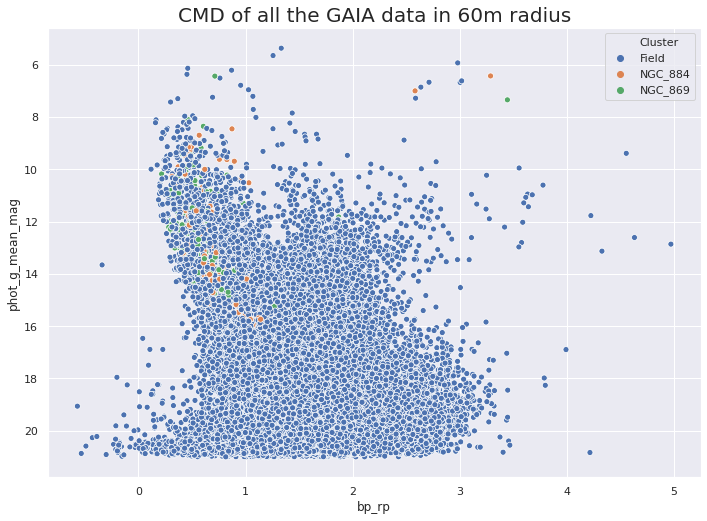

In [273]:
# CMD using all the stars where the membership Probability are expressed as the size of the dots

sns.set(rc={'figure.figsize':(11.7,8.27)})
cmd = sns.scatterplot(all_stars['bp_rp'], all_stars['phot_g_mean_mag'], hue = all_stars['Cluster'])
cmd.invert_yaxis()
plt.title('CMD of all the GAIA data in 60m radius', fontsize=20)
plt.show()

In [274]:
# define the subset of the probable members
potentialMember = all_stars[all_stars['Cluster'] != 'Field']
len(potentialMember)

2640

In [275]:
# comparing the descriptive stats of the all stars vs the probable members
all_stars.describe()

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_good_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_weight_al,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,matched_observations,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,l,b,Ecl_Lon,Ecl_Lat,ruwe,dist_869_center,dist_884_center,PMemb
count,1.633260e+05,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,1.633260e+05,163326.000000,163326.000000,163326.000000,163326.000000,1.633260e+05,163326.000000,163326.000000,163326.000000,163326.000000,1.633260e+05,1.633260e+05,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000,163326.000000
mean,4.588903e+17,35.249310,0.266500,57.123611,0.322645,0.413819,0.431819,3.181345,0.180266,0.912828,-0.821530,0.880647,0.293369,-0.110361,-0.038940,-0.053057,-0.189579,-0.098900,0.017022,0.205564,0.134853,0.268971,239.901810,238.620056,2.116682,371.666656,5.423265,-0.025932,27.523878,12.060541,0.943617,29.887550,250.072983,1.732696e+04,20.173113,653.866455,18.598814,24.022036,8.212185e+03,37.930962,75.747673,19.154264,24.785227,1.356148e+04,5.843464e+01,147.162552,17.672033,1.479279,1.482227,0.555314,0.926908,134.893295,-3.656756,54.499191,40.232857,1.080370,1.029170,0.990467,0.843940
std,7.335022e+14,0.912213,0.238916,0.490569,0.279460,0.871888,0.377316,8.863905,4.608606,0.863898,3.460062,0.847197,0.117073,0.153656,0.215264,0.148637,0.154132,0.155727,0.206768,0.211286,0.196139,0.177163,35.655647,35.531265,7.720475,3123.673340,29.261604,0.050912,3.899417,1.300019,0.910999,4.178869,37.596611,6.570675e+05,1553.848267,791.254150,1.771106,6.029893,2.856375e+05,2008.557129,143.775833,1.750766,5.593812,5.911674e+05,4.226324e+03,333.159302,1.649648,0.293143,0.368505,0.287920,0.222459,0.497479,0.489272,0.644746,0.493546,0.565669,0.512540,0.460520,0.093629
min,4.567620e+17,33.407810,0.011821,56.125404,0.015089,-12.794368,0.019176,-14.840700,-122.783409,0.034038,-216.122986,0.036343,-0.754096,-0.842251,-0.884759,-0.758321,-0.841379,-0.771812,-0.833554,-0.804824,-0.823640,-0.747849,53.000000,53.000000,-9.554250,38.670731,0.005601,-0.397375,7.000000,6.000000,0.045718,7.000000,52.000000,7.505709e+01,0.675644,17.073570,5.368364,2.000000,5.995071e+00,0.074867,0.015559,6.024450,2.000000,3.896466e+01,1.231269e-02,0.682940,4.691905,0.796799,-0.570522,-1.652485,-0.185374,133.887482,-4.652285,53.193134,39.236107,0.714039,0.001752,0.001112,0.343000
25%,4.582872e+17,34.517330,0.082200,56.727986,0.104269,0.087967,0.136208,0.250314,-1.320426,0.260810,-1.642949,0.262220,0.226554,-0.212689,-0.191158,-0.140100,-0.293851,-0.197573,-0.108838,0.081750,0.014332,0.163713,223.000000,221.000000,0.264521,229.872547,0.060837,-0.058128,26.000000,11.000000,0.267999,28.000000,233.000000,1.980196e+02,1.083136,184.363426,17.700006,21.000000,9.204433e+01,7.322753,10.487468,18.322470,23.000000,2.218129e+02,6.960397e+00,27.906547,16.869885,1.301322,1.254624,0.426193,

In [276]:
potentialMember.describe()

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_good_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_weight_al,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,matched_observations,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,l,b,Ecl_Lon,Ecl_Lat,ruwe,dist_869_center,dist_884_center,PMemb
count,2.640000e+03,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2.640000e+03,2640.000000,2640.000000,2640.000000,2640.000000,2.640000e+03,2640.000000,2640.000000,2640.000000,2640.000000,2.640000e+03,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000
mean,4.584140e+17,35.140930,0.026480,57.164146,0.035581,0.410445,0.044868,10.398742,-0.620006,0.082598,-1.069949,0.094208,0.303228,0.007197,-0.068054,-0.109873,-0.160167,-0.161384,-0.118840,0.266729,0.161548,0.307583,246.795456,245.024246,-0.093644,250.806885,61.663025,0.006552,28.227652,12.434469,0.098039,30.926136,257.281433,1.727491e+05,272.478729,2461.402588,14.702829,26.961363,8.529155e+04,299.960022,385.209045,15.063607,26.581440,1.326522e+05,748.564148,578.966797,14.158809,1.242652,0.904815,0.360795,0.544018,134.819656,-3.634517,54.454124,40.297329,0.989966,0.625012,0.701577,0.778973
std,1.573434e+14,0.649279,0.010992,0.220093,0.014832,0.087376,0.018964,4.081747,0.507124,0.035336,0.315290,0.038830,0.086098,0.102161,0.150377,0.086929,0.111877,0.093080,0.161148,0.134923,0.131421,0.113812,25.715376,25.612015,4.322146,136.747589,93.311073,0.046937,2.900799,0.900645,0.038138,2.610833,25.975079,1.626589e+06,5852.173828,1050.435425,1.604742,4.000103,6.394479e+05,3419.981445,192.268753,1.717163,4.111852,1.787439e+06,17622.414062,264.559692,1.480526,0.052229,0.318328,0.161087,0.163367,0.332524,0.249261,0.446557,0.237133,0.104290,0.483103,0.431442,0.188667
min,4.570401e+17,33.435268,0.012348,56.159260,0.015246,0.117788,0.019285,1.517080,-1.201810,0.034970,-8.035069,0.039185,-0.303634,-0.692141,-0.650744,-0.479652,-0.595406,-0.542515,-0.527836,-0.361992,-0.455792,-0.135569,111.000000,111.000000,-9.335344,80.198067,0.810220,-0.235193,13.000000,7.000000,0.047043,17.000000,121.000000,1.213632e+03,1.851609,136.351395,6.430795,2.000000,4.277298e+02,5.595552,15.101190,6.726913,2.000000,1.256667e+03,7.267542,12.212140,5.131482,1.172027,0.202333,-0.130904,0.143405,133.904343,-4.539687,53.263584,39.247608,0.777577,0.003802,0.006608,0.343000
25%,4.583720e+17,34.679079,0.018979,57.064624,0.025630,0.369324,0.032061,7.704525,-0.745970,0.058579,-1.167434,0.067866,0.249114,-0.053081,-0.168341,-0.167951,-0.229859,-0.222950,-0.233683,0.195375,0.084903,0.233108,233.000000,231.000000,-2.558866,184.305950,9.611607,-0.023490,27.000000,12.000000,0.071457,29.000000,243.000000,8.770812e+03,5.064809,1637.056488,13.876035,25.000000,4.245201e+03,15.936984,239.242950,14.133175,25.000000,6.770387e+03,15.625003,396.646271,13.449635,1.212470,0.665583,0.243589,0.421905,134.590508,-3.773808,54.143221,40.163857,0.936087,0.226781,0.321717,0.605000
50%,4.584071e+17,35.03

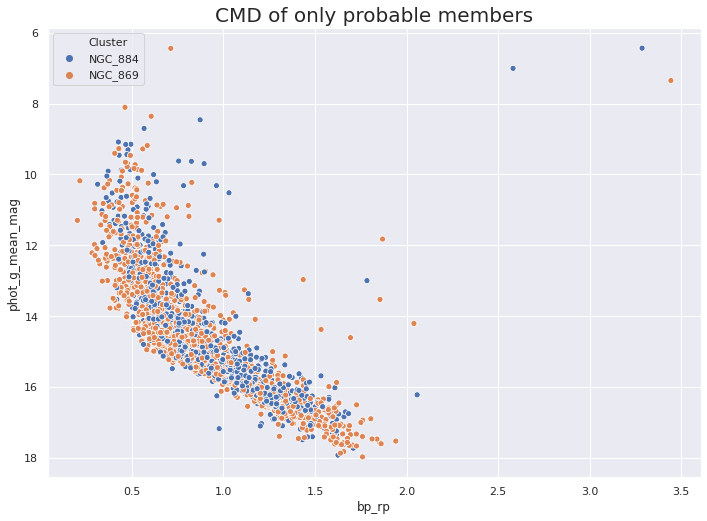

In [277]:
# CMD of only probable members 

sns.set(rc={'figure.figsize':(11.7,8.27)})
cmd2 = sns.scatterplot(potentialMember['bp_rp'], potentialMember['phot_g_mean_mag'], hue = potentialMember['Cluster'])
# plt.ylim(5,18)
cmd2.invert_yaxis()
plt.title('CMD of only probable members', fontsize=20)
plt.show()


### Comparing the new and old probable members

In [278]:
# creating subset for the potential member in previous dataset

potential_Old_Member = member[member['Cluster'] != 'Field']


concatenated = pd.concat([potentialMember.assign(dataset='New_member'), potential_Old_Member.assign(dataset='Old_member')])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [279]:
concatenated

,Cluster,Ecl_Lat,Ecl_Lon,PMemb,astrometric_chi2_al,astrometric_gof_al,astrometric_matched_observations,astrometric_n_good_obs_al,astrometric_n_obs_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,astrometric_sigma5d_max,astrometric_weight_al,b,bp_g,bp_rp,dataset,dec,dec_error,dec_parallax_corr,dec_pmdec_corr,dec_pmra_corr,dist_869_center,dist_884_center,g_rp,l,mag,matched_observations,mean_varpi_factor_al,parallax,parallax_error,parallax_over_error,parallax_pmdec_corr,parallax_pmra_corr,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_bp_n_obs,phot_bp_rp_excess_factor,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_g_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_rp_n_obs,pmdec,pmdec_error,pmra,pmra_error,pmra_pmdec_corr,ra,ra_dec_corr,ra_error,ra_parallax_corr,ra_pmdec_corr,ra_pmra_corr,ruwe,source_id,visibility_periods_used
2,NGC_884,40.234562,54.504868,0.767,293.048492,-0.135504,35.0,302.0,304.0,NaN,NaN,0.088532,11.429910,-3.652415,0.522591,1.229553,New_member,57.124531,0.031806,-0.232977,-0.243002,-0.167748,0.504684,0.341164,0.706963,134.891968,NaN,36.0,-0.022950,0.401020,0.040829,9.821923,0.214054,0.352679,4607.870605,12.640005,364.546600,16.19264,31.0,1.270050,10170.145508,5.189207,1959.864990,15.67005,309.0,8308.718750,12.471944,666.192688,14.96309,30.0,-0.976388,0.078845,-0.576387,0.074206,0.300213,35.254669,0.278386,0.024347,0.034167,-0.086290,-0.114677,1.050665,4.584538e+17,13.0
10,NGC_884,40.231632,54.503201,0.787,267.131012,-0.566807,33.0,286.0,288.0,NaN,NaN,0.067558,36.332199,-3.655388,0.255150,0.710576,New_member,57.121338,0.021856,-0.207715,-0.299207,-0.205661,0.504893,0.341008,0.455426,134.893143,NaN,34.0,-0.025436,0.384170,0.027903,13.768250,0.216155,0.385738,17614.486328,43.595070,404.047607,14.73671,32.0,1.227654,30389.308594,8.834887,3439.694092,14.48156,292.0,19693.058594,34.383877,572.741089,14.02614,32.0,-0.963002,0.055810,-0.605622,0.049645,0.326671,35.254845,0.268039,0.016528,0.099229,-0.113754,-0.080294,1.059815,4.584538e+17,13.0
24,NGC_869,40.244968,54.500355,0.759,212.017105,-2.445552,31.0,270.0,277.0,NaN,NaN,0.080845,21.791759,-3.647501,0.366158,0.918400,New_member,57.132481,0.027617,-0.341333,-0.137647,-0.167557,0.490783,0.355147,0.552241,134.882141,NaN,33.0,-0.032415,0.484269,0.035597,13.604330,0.100712,0.332037,9575.910156,16.547396,578.695923,15.39844,27.0,1.231759,18299.294922,8.676045,2109.175049,15.03228,277.0,12964.403320,26.045515,497.759491,14.48004,25.0,-1.033756,0.071403,-0.539158,0.061655,0.359968,35.240765,0.282554,0.020623,0.019258,-0.061744,-0.143822,0.983706,4.584568e+17,13.0
29,NGC_869,40.246456,54.504620,0.846,191.408493,-1.831358,27.0,234.0,236.0,NaN,NaN,0.078904,36.426270,-3.644145,0.308433,0.803698,New_member,57.135212,0.025876,-0.361530,-0.194289,-0.219009,0.495078,0.350952,0.495266,134.883392,NaN,28.0,-0.003073,0.405381,0.031584,12.835220,0.157782,0.292646,16828.130859,31.790741,529.340576,14.78630,25.0,1.224115,30492.984375,8.094917,3766.929932,14.47787,241.0,20498.779297,36.137417,567.245300,13.98260,25.0,-1.095015,0.069994,-0.720156,0.053957,0.344488,35.245029,0.219077,0.018350,0.023386,-0.125451,-0.170754,1.024738,4.584568e+17,13.0
63,NGC_869,40.252739,54.504093,0.764,245.691498,0.106573,29.0,249.0,249.0,NaN,NaN,0.069126,83.071411,-3.639992,0.218200,0.608327,New_member,57.140724,0.020060,-0.285707,-0.240586,-0.197132,0.489587,0.356750,0.390127,134.878662,NaN,30.0,0.038884,0.362868,0.023622,15.361240,0.101836,0.283634,40193.808594,73.789078,544.712219,13.84099,23.0,1.209893,67023.984375,19.436129,3448.423096,13.62279,254.0,40898.074219,112.878792,362.318512,13.23266,22.0,-0.847881,0.055853,-0.804574,0.043446,0.405929,35.239429,0.305304,0.014607,0.004718,-0.123308,-0.192087,1.099094,4.584568e+17,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

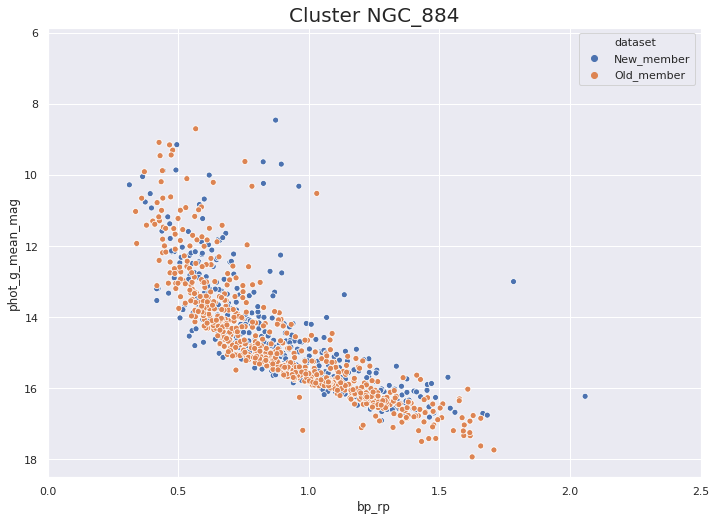

New Member:  1129
Old Member:  621


In [280]:
sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated[concatenated['Cluster'] == 'NGC_884'],
                hue='dataset').invert_yaxis()
plt.xlim(0,2.5)
plt.title('Cluster NGC_884', fontsize = 20)
plt.show()

print('New Member: ', len(potentialMember[potentialMember['Cluster'] == 'NGC_884']))
print('Old Member: ', len(potential_Old_Member[potential_Old_Member['Cluster'] == 'NGC_884']))

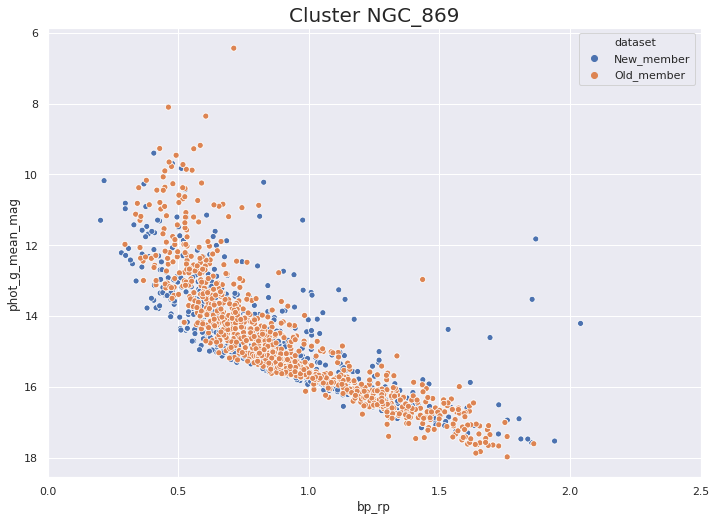

New Member:  1511
Old Member:  920


In [281]:
cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated[concatenated['Cluster'] == 'NGC_869'],
                hue='dataset')
cmd.invert_yaxis()
plt.xlim(0,2.5)
plt.title('Cluster NGC_869', fontsize = 20)
plt.show()

print('New Member: ', len(potentialMember[potentialMember['Cluster'] == 'NGC_869']))
print('Old Member: ', len(potential_Old_Member[potential_Old_Member['Cluster'] == 'NGC_869']))

Text(0.5, 1.0, 'Proper motion of the probable Members')

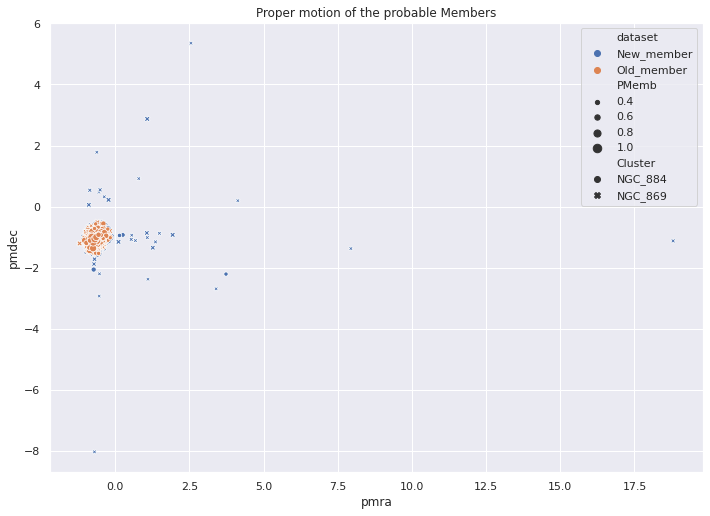

In [286]:
sns.scatterplot(x='pmra', y='pmdec', data=concatenated[concatenated['PMemb'] >= 0.5],
                style='Cluster', hue='dataset', size = 'PMemb')

#plt.xlim(-5,20)
#plt.ylim(-10,10)
plt.title('Proper motion of the probable Members')

In [285]:
len(concatenated.loc[concatenated['PMemb'] >= 0.6, ['dataset', 'Cluster', 'source_id']].duplicated(['source_id']))

3198

Text(0.5, 1.0, 'Skyplot of the probable Members')

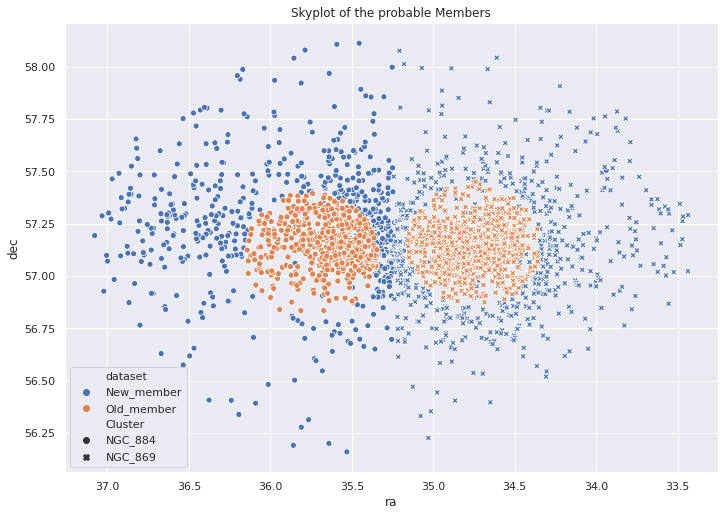

In [287]:
skyplot = sns.scatterplot(x='ra', y='dec', data=concatenated,
                style='Cluster', hue='dataset')
skyplot.invert_xaxis()
plt.title('Skyplot of the probable Members')

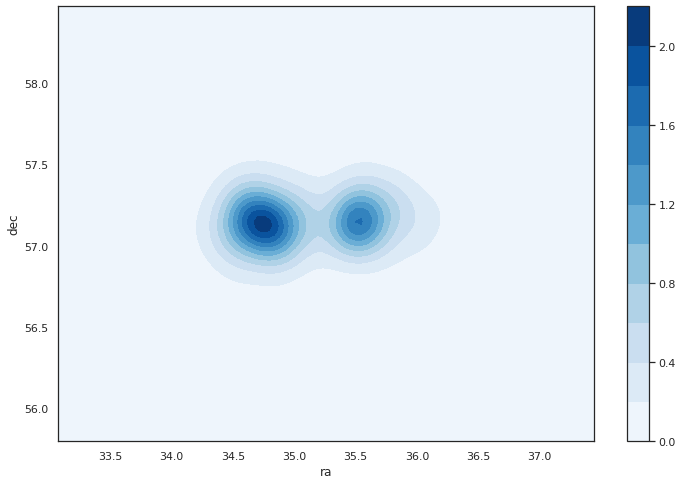

In [288]:
sns.set(rc={'figure.figsize':(12,8)})

x, y = concatenated['ra'], concatenated['dec']
sns.set_style("white")

sns.kdeplot(x, y, cmap="Blues", shade=True, shade_lowest=True, 
            cbar = True, bw = 0.12)
plt.show()

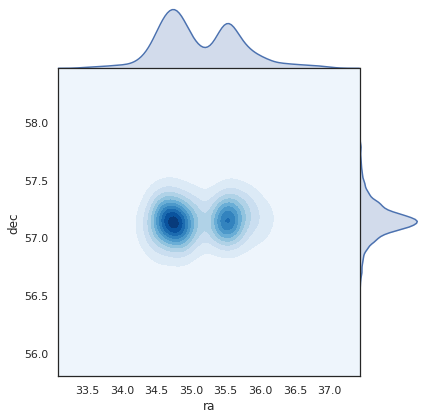

In [289]:
sns.jointplot(x, y, kind="kde", space=0, color="b", bw = 0.12, cmap = 'Blues')

plt.show()

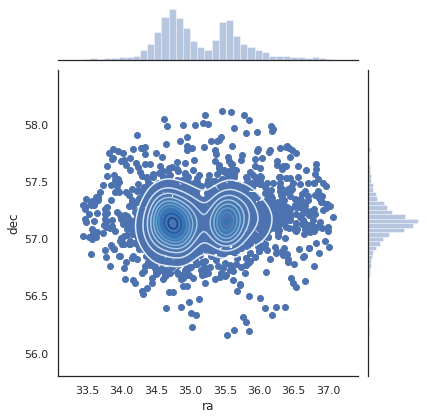

In [290]:
sns.jointplot(x, y, color="b").plot_joint(sns.kdeplot, n_levels = 10, cmap = 'Blues', bw = 0.12)

In [0]:
all_stars.to_csv('binary_cluster_membership_prob.csv')

In [0]:
pd_prof.ProfileReport(all_stars)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,34
Number of observations,53040
Total Missing (%),0.0%
Total size in memory,7.1 MiB
Average record size in memory,140.0 B
Numeric,23
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,10


(array([2.8767e+04, 2.0455e+04, 1.4880e+03, 5.5400e+02, 3.5000e+02,
        3.3000e+02, 3.7900e+02, 4.3100e+02, 2.6200e+02, 2.4000e+01]),
 array([0.111     , 0.1805    , 0.25      , 0.3195    , 0.389     ,
        0.45849999, 0.52799999, 0.59749999, 0.66699999, 0.73649999,
        0.80599999]),
 <a list of 10 Patch objects>)

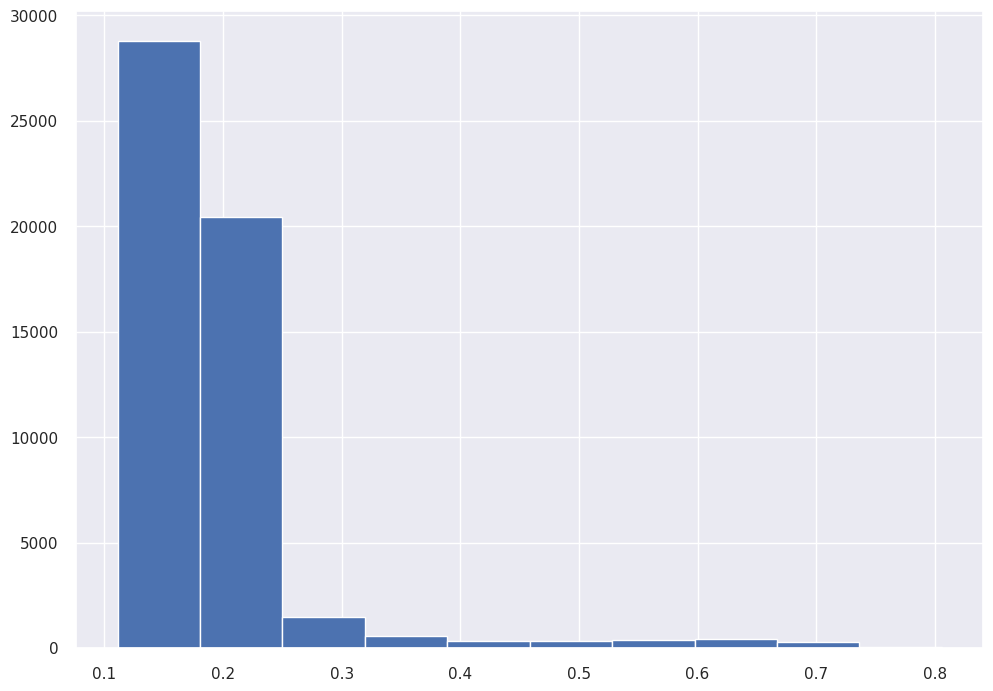

In [0]:
plt.hist(all_stars['PMemb'])